# Food Recognition

Bibliography:
- https://www.kaggle.com/boopesh07/multiclass-food-classification-using-tensorflow
- https://www.kaggle.com/dansbecker/food-101
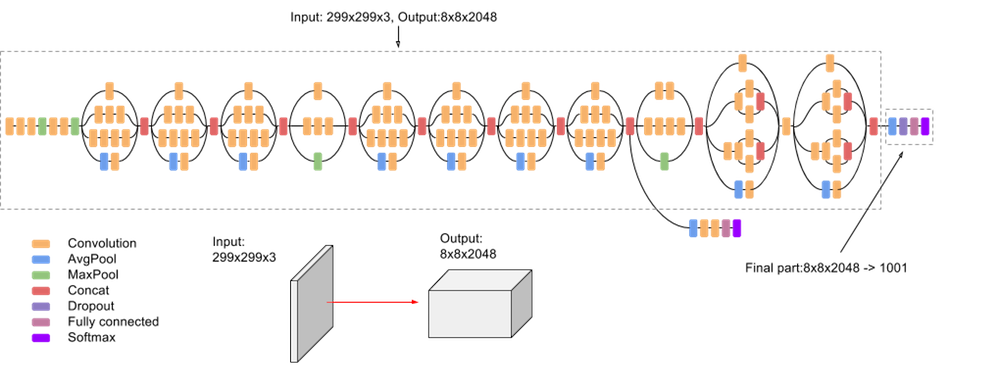

In this  notebook a model is made to predict (classify) food images.
 Based on the prediction of the food category and the weight of the food (entered manually), an estimation of the calories that the food contains can be made.

 steps performed are :
 1. downloading food data from Kaggle  (https://www.kaggle.com/dansbecker/food-101)
 2. Explore different Categories of food, and datasets
 3. Splitting into train and test data
 4. Dataaugmentation with ImageDataGenerator with different parameters
 (https://keras.io/api/preprocessing/image/ & https://theailearner.com/2019/07/06/data-augmentation-with-keras-imagedatagenerator/)
 5.use of Image net: ImageNet has over ten million URLs of labeled images. About a million of the images also have bounding boxes specifying a more precise location for the labeled objects.
 6. Building model 
 7.training the model with 3classes of food  verifying the results
 8. Increasing the food classes to 10 classes and verifying the model reults

 PS: data set is kept mini dataset with about 11000 images, because each epoch was taking very longer, With increasing number of food classes the time taken would be too long as an hour per epoch. 
 hence a demonstrative model is presented below. 


In [1]:
# import the necesarry libraries
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

Then, enable GPUs for the notebook, 
- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.5.0
/device:GPU:0


Now, download the data: 

The dataset being used is **Food 101** (https://www.kaggle.com/dansbecker/food-101)

This dataset has 101000 images in total. It's a food dataset with 101 categories (multiclass).
Each type of food has 750 training samples and 250 test samples.

Note found on the webpage of the dataset :
On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

The entire dataset is 5GB in size

**meta folder** contains the text files - train.txt and test.txt

**train.txt** contains the list of images that belong to training set

**test.txt** contains the list of images that belong to test set

**classes.txt** contains the list of all classes of food

In [3]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
get_data_extract()

--2021-06-10 11:30:23--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-06-10 11:30:23--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz      14%[=>                  ] 709.26M  29.7MB/s    eta 2m 24s 

### **Explore the dataset structure and files**

In [ ]:
# Check the extracted dataset folder
!ls food-101/


In [ ]:
#list the different food categories in the dataset
os.listdir('food-101/images')

['macaroni_and_cheese',
 'grilled_cheese_sandwich',
 'apple_pie',
 'escargots',
 'lasagna',
 'scallops',
 'panna_cotta',
 'lobster_roll_sandwich',
 'pad_thai',
 'guacamole',
 'breakfast_burrito',
 'garlic_bread',
 'french_onion_soup',
 'foie_gras',
 'ice_cream',
 'ceviche',
 'hamburger',
 'oysters',
 'edamame',
 'gnocchi',
 'beignets',
 'cheese_plate',
 'greek_salad',
 'pork_chop',
 'spaghetti_carbonara',
 'donuts',
 'fried_rice',
 'clam_chowder',
 'samosa',
 'deviled_eggs',
 'french_toast',
 'takoyaki',
 'bibimbap',
 'tuna_tartare',
 'caprese_salad',
 'ramen',
 'gyoza',
 'poutine',
 'waffles',
 'hot_and_sour_soup',
 'sashimi',
 'miso_soup',
 'ravioli',
 'sushi',
 'filet_mignon',
 'steak',
 'cup_cakes',
 'omelette',
 'spaghetti_bolognese',
 'caesar_salad',
 'fish_and_chips',
 'beef_tartare',
 'croque_madame',
 'fried_calamari',
 'pancakes',
 'huevos_rancheros',
 'hot_dog',
 'chicken_curry',
 'chocolate_mousse',
 'onion_rings',
 'eggs_benedict',
 'french_fries',
 'churros',
 'beef_carpa

In [ ]:
#take a look at the metadata
os.listdir('food-101/meta') 

['test.txt',
 'labels.txt',
 'train.json',
 'train.txt',
 'classes.txt',
 'test.json']

In [ ]:
#take a look at the first instances of train.txt
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
#take a look at the different classes
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **visualize random images of the different classes to get an idea of what is in the dataset**

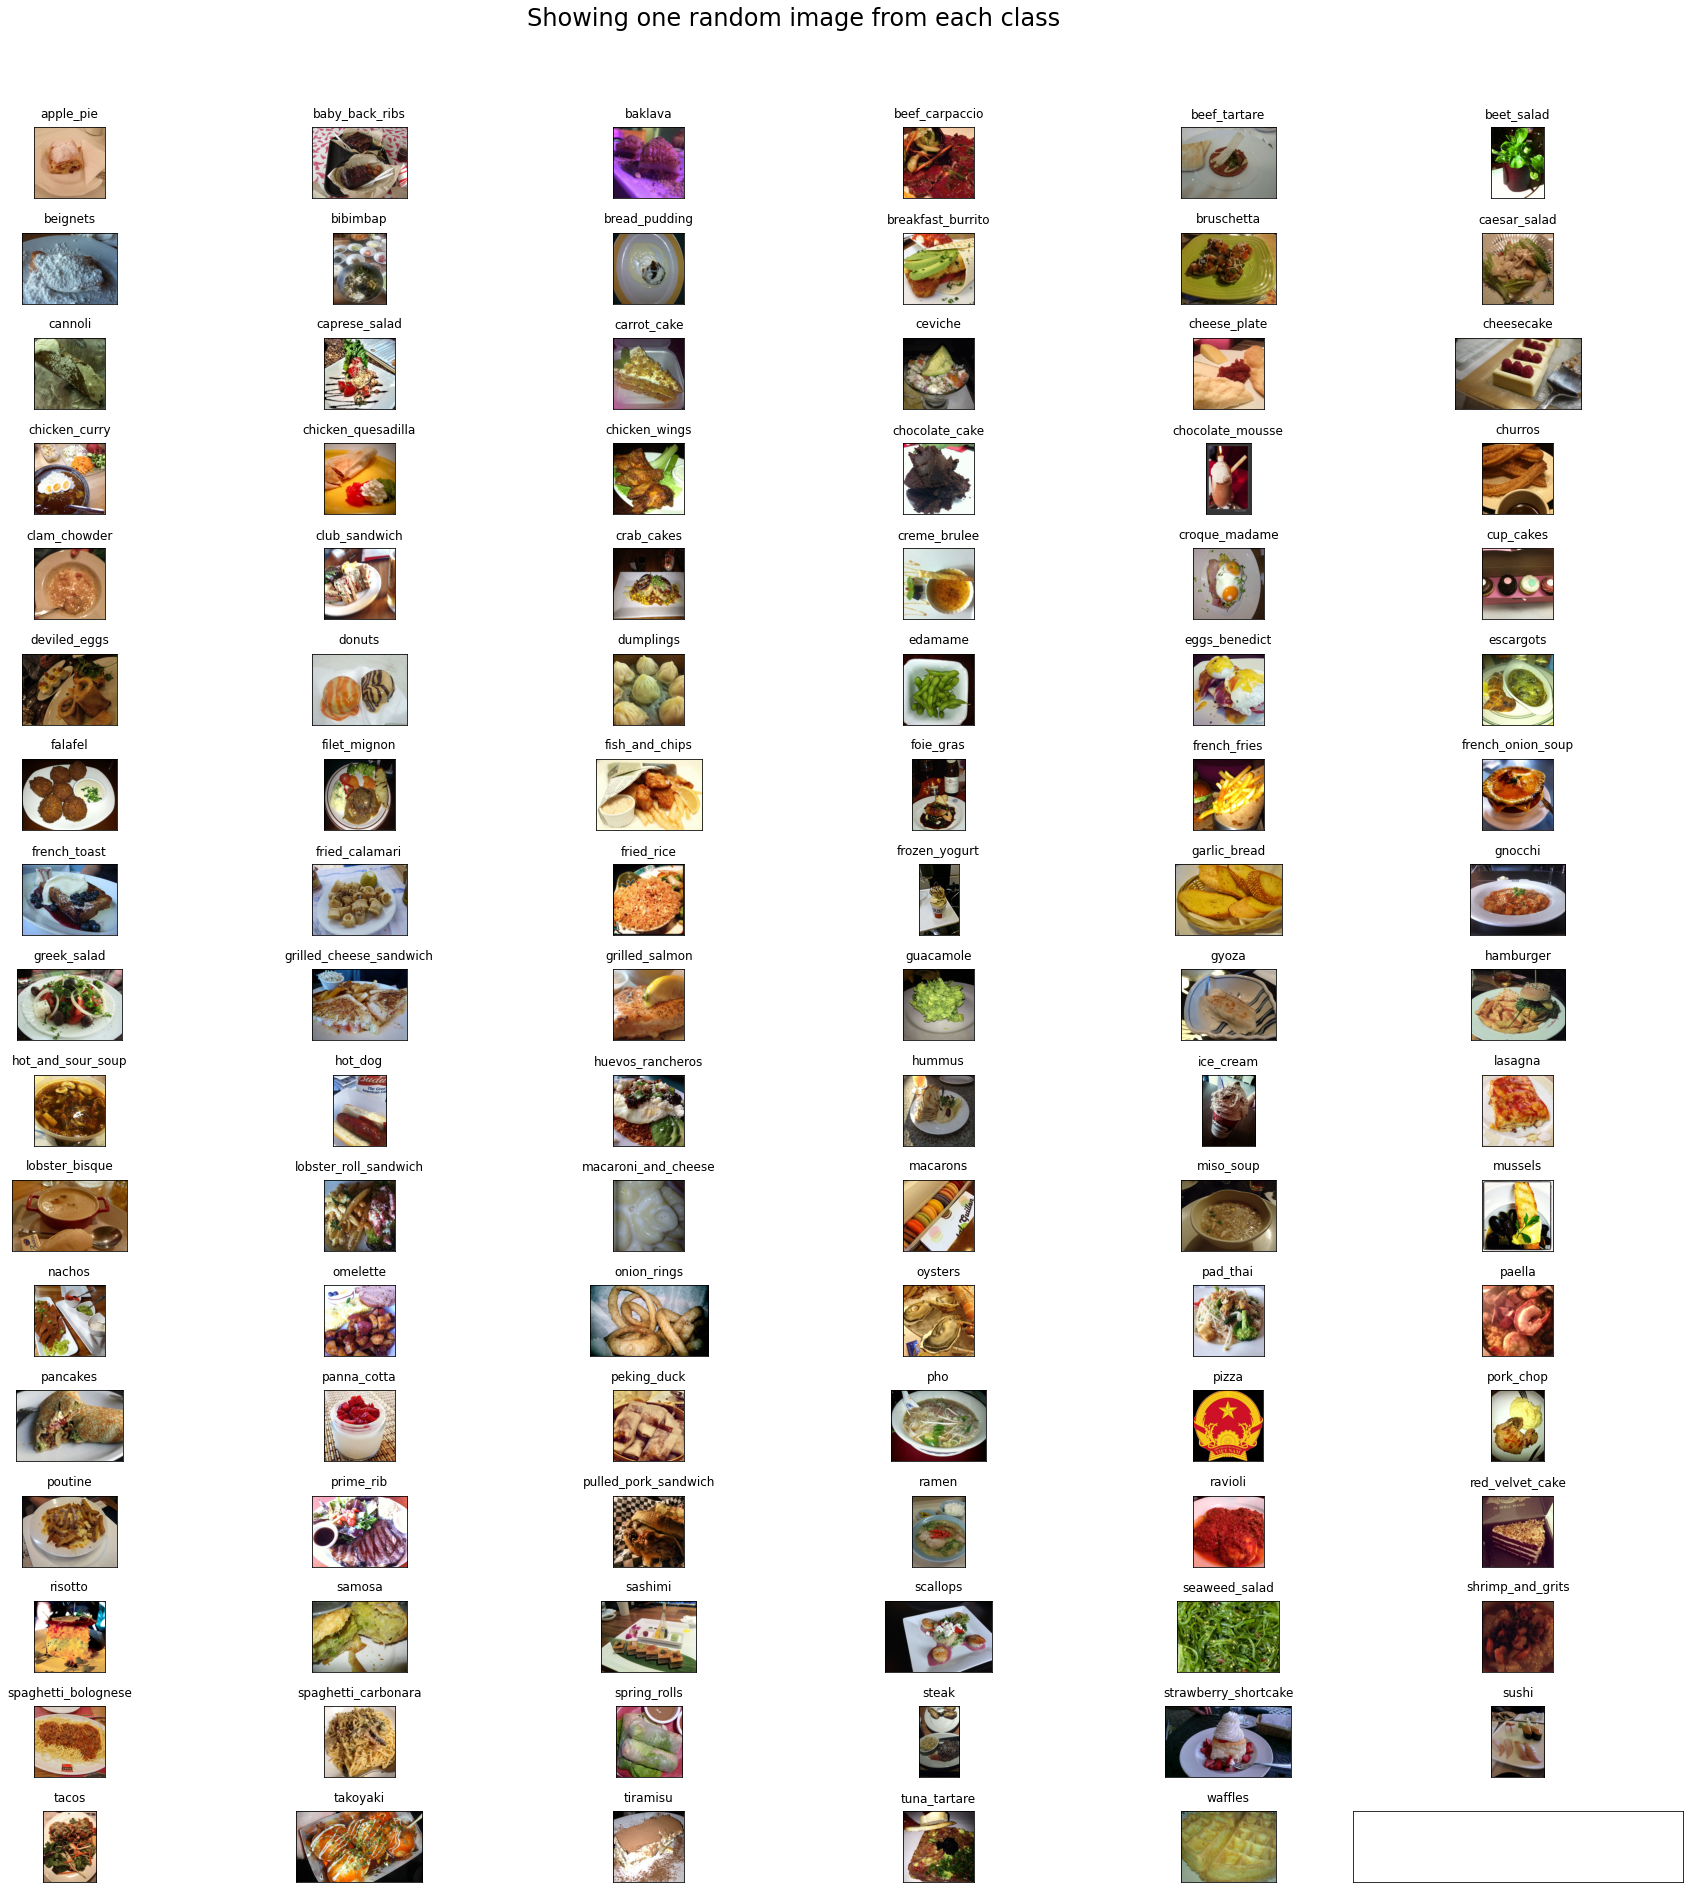

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

### **Split the image data into train and test using train.txt and test.txt**

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to the folder train using the file train.txt

print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**
For experimenting and trying different architectures, it is better to work with a smaller dataset in order to save time and computation.
Three classes are used because the original problem is a multiclass classification problem which makes the key aspects of architectural decisions different from that of binary classification.

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
##del foods_sorted[0] # remove .DS_Store from the list --> I think it is already deleted, but we should check that

In [ ]:
#foods_sorted

In [ ]:
# NN
#Helper method to create train_mini and test_mini data samples with just 3 classes
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [ ]:
# NN
#picking 3 food items and generating separate data folders for the same
food_list = ['huevos_rancheros','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'


In [ ]:
#NN
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into huevos_rancheros
Copying images into pizza
Copying images into omelette


In [ ]:
#check the number of samples in the train folder
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [ ]:
#NN
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into huevos_rancheros
Copying images into pizza
Copying images into omelette


In [ ]:
#NN
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### **Building models**

***preprocessing the data***

In [ ]:
#NN
#set values
n_classes = 3
img_width, img_height=299,299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

Use ImageDataGenerator for data augmentation 

ImageDataGenerator generates batches of tensor image data with real-time data augmentation, The data will be looped over (in batches).
(https://keras.io/api/preprocessing/image/ & https://theailearner.com/2019/07/06/data-augmentation-with-keras-imagedatagenerator/)

Parameters ImageDataGenerator: 
- rescaling standardizes pixel values to [0,1]
- shear_range: to augment images so that computers can see how humans see things from different angles.
(https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras)
- zoom range: range for a random zoom
- horizontal_flip: Boolean. Randomly flip inputs horizontally.
- veritcal_flip: Boolean. Randomly flip inputs horizontally.
- rotation_range: This rotates each image up to the angle specified. 
- brightness_range: This produces images similar to as taken with different lighting conditions. In this, you pass the min and the max range based on which the image will be darkened or brightened. Values <1 darkens the image, >1 brightens the image and =1 means no change. For example, below line darkens the image as shown



flow from directory method: Takes the path to a directory & generates batches of augmented data. (https://keras.io/api/preprocessing/image/)

Parameters flow_from_directory:
- directory: string, path to the target directory. It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.
- target size: The dimensions to which all images found will be resized. many deep learning model architectures require that our images are the same size and our raw collected images may vary in size. (https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/#:~:text=Resizing%20images%20is%20a%20critical,and%20that%20time%20adds%20up.)
- classes: Default: None. If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under directory, where each subdirectory will be treated as a different class (and the order of the classes, which will map to the label indices, will be alphanumeric)
- class_mode: Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels.
- save_to_dir: None or str (default: None). This allows you to optionally specify a directory to which to save the augmented pictures being generated (useful for visualizing what you are doing).

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range= 45,
    brightness_range=[0.2,0.8],
    horizontal_flip=True, 
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
  
    #save_to_dir='augmented_data_train',
    #save_format='jpeg'

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

    #save_to_dir='augmented_data_test',
    #save_format='jpeg'

FileNotFoundError: ignored

***train a model***

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
140/140 [==============================] - 108s 483ms/step - loss: 1.0838 - accuracy: 0.4530 - val_loss: 0.8934 - val_accuracy: 0.6821

Epoch 00001: val_loss improved from inf to 0.89344, saving model to best_model_3class.hdf5
Epoch 2/30
140/140 [==============================] - 63s 452ms/step - loss: 0.8807 - accuracy: 0.6406 - val_loss: 0.7272 - val_accuracy: 0.7731

Epoch 00002: val_loss improved from 0.89344 to 0.72723, saving model to best_model_3class.hdf5
Epoch 3/30
140/140 [==============================] - 64s 453ms/step - loss: 0.7640 - accuracy: 0.7068 - val_loss: 0.6149 - val_accuracy: 0.8016

Epoch 00003: val_loss improved from 0.72723 to 0.61492, saving model to best_model_3class.hdf5
Epoch 4/30
140/140 [==============================] - 64s 458ms/step - loss: 0.6763 - accuracy: 0.7417 - val_loss: 0.5537 - val_accuracy: 0.7976

Epoch 00004: val_loss improved from 0.61492 to 0.55369, saving model to best_model_3class.hdf5
Epoch 5/30
140/140 [===================

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'huevos_rancheros': 0, 'omelette': 1, 'pizza': 2}

Visualize the accuracy and loss plots

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

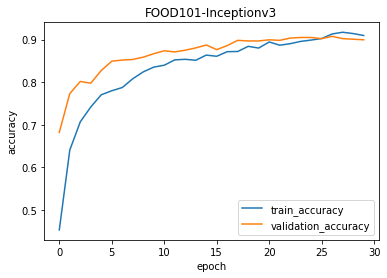

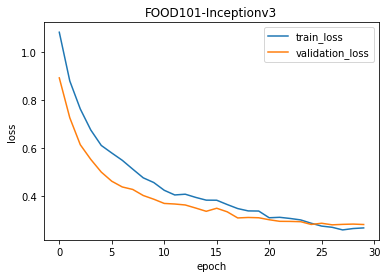

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

The plots show that the accuracy of the model increased with epochs and the loss has decreased
Validation accuracy has been on the higher side than training accuracy for many epochs
This could be for several reasons:
We used a pretrained model trained on ImageNet which contains data from a variety of classes
Using dropout can lead to a higher validation accuracy

Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 1.9 s, sys: 69.4 ms, total: 1.97 s
Wall time: 1.94 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O pizza.jpg https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Ffr%2Fphotos%2Fpizza&psig=AOvVaw3jsoUV-jvfFXEPTffOWKHa&ust=1623268035082000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCPjMsebmiPECFQAAAAAdAAAAABAD
!wget -O omelette.jpg https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.shutterstock.com%2Fsearch%2Fegg%2Bomlet&psig=AOvVaw1JwSeoy2CiQcjQ9fi9ctCR&ust=1623268219308000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNibqb7niPECFQAAAAAdAAAAABAD

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2021-06-08 19:50:42--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   229KB/s    in 0.3s    

2021-06-08 19:50:43 (229 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2021-06-08 19:50:43--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K  --.-KB/s    in 0.03

Setting compile=False and clearing the session leads to faster loading of the saved model
Withouth the above addiitons, model loading was taking more than a minute!

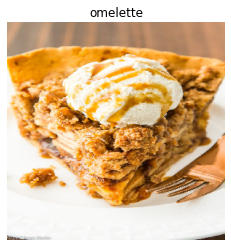

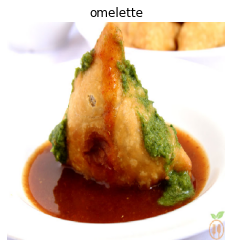

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('samosa.jpg')
#images.append('pizza.jpg')
#images.append('omelette.jpg')
predict_class(model_best, images, True)

Fine tune Inceptionv3 model with 11 classes of data
We trained a model on 3 classes and tested it using new data
The model was able to predict the classes of all three test images correctly
Will it be able to perform at the same level of accuracy for more classes?
FOOD-101 dataset has 101 classes of data
Even with fine tuning using a pre-trained model, each epoch was taking more than an hour when all 101 classes of data is used(tried this on both Colab and on a Deep Learning VM instance with P100 GPU on GCP)
But to check how the model performs when more classes are included, I'm using the same model to fine tune and train on 11 randomly chosen classes

In [ ]:

 #Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:

# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:

# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
#NNprint("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
#NN
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

In [ ]:

print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

In [ ]:

# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')

Found 8250 images belonging to 11 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
 89/515 [====>.........................] - ETA: 2:38 - loss: 2.5165 - accuracy: 0.1376

KeyboardInterrupt: ignored

In [ ]:

class_map_11 = train_generator.class_indices
class_map_11

In [ ]:

plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

The plots show that the accuracy of the model increased with epochs and the loss has decreased
Validation accuracy has been on the higher side than training accuracy for many epochs
This could be for several reasons:
We used a pretrained model trained on ImageNet which contains data from a variety of classes
Using dropout can lead to a higher validation accuracy

In [ ]:

%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

In [ ]:

# Downloading images from internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
!wget -O pizza.jpg https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Ffr%2Fphotos%2Fpizza&psig=AOvVaw3OEW5QpfO531v1X4GtFA7p&ust=1623246773800000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCOjAwsyXiPECFQAAAAAdAAAAABAH
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


# from google.colab import files
# image = files.upload()

In [ ]:

# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

The model did well even when the number of classes are increased to 11
Model training on all 101 classes takes some time
It was taking more than an hour for one epoch when the full dataset is used for fine tuning

In [ ]:
n


11

In [ ]:

# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n=101
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750 # 8250
nb_validation_samples = 25250 #2750 #
batch_size = 100

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_class.log')

history_class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_class.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
757/757 [==============================] - 2840s 4s/step - loss: 5.1916 - accuracy: 0.0135 - val_loss: 5.1107 - val_accuracy: 0.0240

Epoch 00001: val_loss improved from inf to 5.11075, saving model to best_model_class.hdf5
Epoch 2/30
757/757 [==============================] - 2817s 4s/step - loss: 5.0699 - accuracy: 0.0345 - val_loss: 4.9706 - val_accuracy: 0.0696

Epoch 00002: val_loss improved from 5.11075 to 4.97056, saving model to best_model_class.hdf5
Epoch 3/30
757/757 [==============================] - 2761s 4s/step - loss: 4.9086 - accuracy: 0.0769 - val_loss: 4.7224 - val_accuracy: 0.1415

Epoch 00003: val_loss improved from 4.97056 to 4.72236, saving model to best_model_class.hdf5
Epoch 4/30
757/757 [==============================] - 2734s 4s/step - loss: 4.6484 - accuracy: 0.1378 - val_loss: 4.3537 - val_accuracy: 0.2211

Epoch 00004: val_loss improved from 4.72236 to 4.35371, saving model to best_model_class.hdf5
Epoch 5/30
757/757 [============================